In [2]:
import os
import time
import datetime
import netCDF4
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.cluster import DBSCAN

In [3]:
s3bands = [
    'B1-400',
    'B2-412.5',
    'B3-442.5',
    'B4-490',
    'B5-510',
    'B6-560',
    'B7-620',
    'B8-665',
    'B9-673.75',
    'B10-681.25',
    'B11-708.75',
    'B12-753.75',
    'B16-778.75',
    'B17-865',
    'B18-885',
    'B21-1020'
]

# s3bands = [400, 412.5, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1020]

In [4]:
def datafolder_2_list(path):
    return [f for f in path.iterdir() if f.suffix == '.csv']


def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band='B21-1020'):

    if norm_band is not None:
        df = normalize(df, s3bands, 'B21-1020')

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path, min_pixels=10):

    csvs = [f for f in path.iterdir()]

    radiometries = {}

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > min_pixels:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries


def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

def power(x, a, b, c):return a*(x)**(b) + c


def SPM_GET_Amazon(band665, band865, cutoff_value=0.027, cutoff_delta=0.007, low_params=None, high_params=None, debug=False):
    
    b665 = band665/np.pi
    b865 = band865/np.pi
    
    if debug:
        pdb.set_trace()

    if cutoff_delta == 0:
        transition_coef = np.where(b665<=cutoff_value, 0, 1)

    else:
        transition_range = (cutoff_value - cutoff_delta, cutoff_value + cutoff_delta)
        transition_coef = (b665-transition_range[0])/(transition_range[1]-transition_range[0])

        transition_coef = np.clip(transition_coef, 0, 1)


    # if params are not passed, use default params obtained from the Amazon dataset
    low_params = [2.79101975e+05, 2.34858344e+00, 4.20023206e+00] if low_params is None else low_params
    high_params = [848.97770516,   1.79293191,   8.2788616 ] if high_params is None else high_params

    #low = Fit.power(b665, *low_params).fillna(0)
    #high = Fit.power(b865/b665, *high_params).fillna(0)

    low = power(b665, *low_params).fillna(0)
    high = power(b865/b665, *high_params).fillna(0)


    spm = (1-transition_coef)*low + transition_coef*high
    return spm


# https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date
def from_excel_ordinal(ordinal, _epoch0=datetime.datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + datetime.timedelta(days=ordinal)).replace(microsecond=0)

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

def create_time_series_cluster(radiometries, eps=0.01, min_samples=5):
    df = pd.DataFrame()

    for date, radiometry in radiometries.items():

        # clean some outliars  using the indices
        calc_nd_index(radiometry, 'B6-560', 'B21-1020', column_name='mndwi')  # Green / SWIR
        calc_nd_index(radiometry, 'B6-560', 'B17-865', column_name='ndwi')  # Green / IR

        valid_mndwi = (radiometry['mndwi'] > -0.99) & (radiometry['mndwi'] < 0.99)
        valid_ndwi = (radiometry['ndwi'] > -0.99) & (radiometry['ndwi'] < 0.99)

        radiometry = radiometry[valid_mndwi & valid_ndwi]

        if len(radiometry) < min_samples:
            continue 
        
        db_scan(radiometry, ['B17-865', 'B21-1020'], eps=eps, min_samples=min_samples)
        clusters = radiometry.groupby(by='cluster').mean()

        # drop the noise
        clusters.drop(-1, inplace=True, errors='ignore')

        # if there is at least 1 valid cluster
        if len(clusters) > 0:
            df = df.append(clusters[clusters['B21-1020'] == clusters['B21-1020'].min()].iloc[0].rename(date))
        
    
    df['Datestr'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df.iterrows()]
    df['Date'] = pd.to_datetime(df['Datestr'])
    df.sort_values(by='Date', inplace=True)
    df.reset_index(inplace=True)
    
    return df

## Sentinel-3

In [5]:
raw_csvs = Path('D:\S3\stations')
rawcsvfolders = [raw_csvs/Path(c) for c in os.listdir(raw_csvs)]    
rawcsvfolders

[WindowsPath('D:/S3/stations/12350000_fonte_boa'),
 WindowsPath('D:/S3/stations/12900001_tefe'),
 WindowsPath('D:/S3/stations/13100090_coari'),
 WindowsPath('D:/S3/stations/14100000_manacapuru'),
 WindowsPath('D:/S3/stations/14900050_negro_19'),
 WindowsPath('D:/S3/stations/14900050_negro_2'),
 WindowsPath('D:/S3/stations/14900050_negro_29'),
 WindowsPath('D:/S3/stations/14900050_negro_37'),
 WindowsPath('D:/S3/stations/14910000_negro'),
 WindowsPath('D:/S3/stations/15860000_borba_madeira'),
 WindowsPath('D:/S3/stations/17050001_obidos'),
 WindowsPath('D:/S3/stations/17050001_obidos_(oldManacaImgs)'),
 WindowsPath('D:/S3/stations/AN1'),
 WindowsPath('D:/S3/stations/BCO')]

In [6]:
inputpath = Path('D:\processing\linux')
v15folders = [inputpath/Path(f) for f in os.listdir(inputpath) if f.endswith(('_v15','_v15b','_mnc'))]
v15folders

[WindowsPath('D:/processing/linux/12350000_fonte_boa_v15'),
 WindowsPath('D:/processing/linux/12900001_tefe_v15'),
 WindowsPath('D:/processing/linux/13100090_coari_v15'),
 WindowsPath('D:/processing/linux/14100000_manacapuru_v15'),
 WindowsPath('D:/processing/linux/14190050_negro_19_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_19_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_29_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_2_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_37_v15'),
 WindowsPath('D:/processing/linux/14910000_negro_v15'),
 WindowsPath('D:/processing/linux/15860000_borba_madeira_v15'),
 WindowsPath('D:/processing/linux/17050001_obidos_v15b'),
 WindowsPath('D:/processing/linux/17050001_obidos_v15_mnc'),
 WindowsPath('D:/processing/linux/AN1_v15'),
 WindowsPath('D:/processing/linux/BCO_v15')]

In [7]:
raw_csv_folders = [rawcsvfolders[3],rawcsvfolders[9],rawcsvfolders[10]]
raw_csv_folders

[WindowsPath('D:/S3/stations/14100000_manacapuru'),
 WindowsPath('D:/S3/stations/15860000_borba_madeira'),
 WindowsPath('D:/S3/stations/17050001_obidos')]

In [8]:
v15_csv_folders = [v15folders[3],v15folders[10],v15folders[11]]
v15_csv_folders

[WindowsPath('D:/processing/linux/14100000_manacapuru_v15'),
 WindowsPath('D:/processing/linux/15860000_borba_madeira_v15'),
 WindowsPath('D:/processing/linux/17050001_obidos_v15b')]

### RAW Sentine-3 Radiometries

In [40]:
raw_dfs = {}

t1 = time.perf_counter()

for station in raw_csv_folders:
    sname = station.stem
    print(f'Processing station: {station}')
    base_path = station
    # Get the complete list of raw.csv files inside the input folder.
    csvs = datafolder_2_list(base_path)
    # Create a empty dict to append the Pandas.DataFrame of each csv.
    raw_radiometries = {}
    # Discard DFs with less than min_pixels
    min_pixels = 1
    
    print('reading individual csvs...')
    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) >= min_pixels:
            raw_radiometries[csv.stem[16:24]] = df
    
    print('Done.')
    
    df_raw_mean = pd.DataFrame()
    
    print('Calculating the mean over each day.')
    for date, radiometry in raw_radiometries.items():
        df_raw_mean = df_raw_mean.append(radiometry.mean().rename(date))

    df_raw_mean['Datestr'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_raw_mean.iterrows()]
    df_raw_mean['Date'] = pd.to_datetime(df_raw_mean['Datestr'])
    df_raw_mean.sort_values(by='Date', inplace=True)
    df_raw_mean.reset_index(inplace=True)
    
    raw_dfs[sname] = df_raw_mean
    print('Done.')

t2 = time.perf_counter()
print(f'Done. [{round(t2 - t1, 2)} second(s)]')

Processing station: D:\S3\stations\14100000_manacapuru
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Processing station: D:\S3\stations\15860000_borba_madeira
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Processing station: D:\S3\stations\17050001_obidos
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Done. [25.45 second(s)]


In [10]:
v15_dfs = {}
#v15_rads = {}

t1 = time.perf_counter()

for station in v15_csv_folders:
    sname = station.stem
    print(f'Processing station: {station}')
    base_path = station
    # Get the complete list of raw.csv files inside the input folder.
    csvs = datafolder_2_list(base_path)
    # Create a empty dict to append the Pandas.DataFrame of each csv.
    v15_radiometries = {}
    # Discard DFs with less than min_pixels
    min_pixels = 4 
    
    print('reading individual csvs...')
    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) >= min_pixels:
            v15_radiometries[csv.stem[16:24]] = df
    
    #v15_rads[sname] = v15_radiometries
    print('Done.')
    
    df_v15_mean = pd.DataFrame()
    
    print('Calculating the mean over each day.')
    for date, radiometry in v15_radiometries.items():
        df_v15_mean = df_v15_mean.append(radiometry.mean().rename(date))

    df_v15_mean['Datestr'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_v15_mean.iterrows()]
    df_v15_mean['Date'] = pd.to_datetime(df_v15_mean['Datestr'])
    df_v15_mean.sort_values(by='Date', inplace=True)
    df_v15_mean.reset_index(inplace=True)
    
    v15_dfs[sname] = df_v15_mean
    print('Done.')

t2 = time.perf_counter()
print(f'Done. [{round(t2 - t1, 2)} second(s)]')

Processing station: D:\processing\linux\14100000_manacapuru_v15
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Processing station: D:\processing\linux\15860000_borba_madeira_v15
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Processing station: D:\processing\linux\17050001_obidos_v15b
reading individual csvs...
Done.
Calculating the mean over each day.
Done.
Done. [49.35 second(s)]


## CAMS 2016:2020

In [11]:
camscsvfolder = Path('D:/A1_JM/artigo_SEN3R/2_mat_met/CAMS')

In [12]:
station2cams = [s for s in os.listdir(camscsvfolder) if s.endswith('.csv')]

In [13]:
cams_station_dict = {}
for s in station2cams:
    sname = s.split('.')[0]
    df = pd.read_csv(camscsvfolder/s)
    cams_station_dict[sname] = df

In [14]:
cams_station_dict.keys()

dict_keys(['an1', 'borba_madeira', 'coari', 'fonte_boa', 'itacoatiara', 'manacapuru', 'negro', 'obidos', 'tefe'])

In [49]:
df_cams_manacapuru = cams_station_dict['manacapuru']
df_cams_manacapuru['pydate'] = pd.to_datetime(df_cams_manacapuru['Datetime'])

In [50]:
df_cams_borba = cams_station_dict['borba_madeira']
df_cams_borba['pydate'] = pd.to_datetime(df_cams_borba['Datetime'])

In [51]:
df_cams_obidos = cams_station_dict['obidos']
df_cams_obidos['pydate'] = pd.to_datetime(df_cams_obidos['Datetime'])

## DBSCAN

In [11]:
radiometries = load_radiometries(Path('/d_drive_data/processing/linux/14100000_manacapuru_v15'))
# radiometries = load_radiometries(Path(r'D:\processing\linux\14100000_manacapuru_v15'))
dbs_manacapuru = create_time_series_cluster(radiometries)

In [10]:
radiometries = load_radiometries(Path(r'D:\processing\linux\15860000_borba_madeira_v15'))
dbs_borba = create_time_series_cluster(radiometries)

In [11]:
radiometries = load_radiometries(Path(r'D:\processing\linux\17050001_obidos_v15b'))
dbs_obidos = create_time_series_cluster(radiometries)

In [ ]:
# dbscam_dfs = {}
# t1 = time.perf_counter()

# for station in v15_csv_folders:
#     sname = station.stem
#     print(f'Applying DBSCAN over station: {station}')
#     radiometries = load_radiometries(station)
#     df = create_time_series_cluster(radiometries)
#     dbscam_dfs[sname] = df
    
# t2 = time.perf_counter()
# print(f'Done. [{round(t2 - t1, 2)} second(s)]')

In [22]:
dbs_manacapuru.keys()

Index(['index', 'A865:float', 'ABSVLDPX', 'B1-400', 'B10-681.25', 'B11-708.75',
       'B12-753.75', 'B16-778.75', 'B17-865', 'B18-885', 'B2-412.5',
       'B21-1020', 'B3-442.5', 'B4-490', 'B5-510', 'B6-560', 'B7-620',
       'B8-665', 'B9-673.75', 'GLINT', 'OAA:float', 'OZA:float', 'QUALITY',
       'SAA:float', 'SZA:float', 'T865:float', 'Unnamed: 0', 'WQSF_lsb:double',
       'latitude:double', 'longitude:double', 'mndwi', 'ndwi', 'x', 'y',
       'Datestr', 'Date'],
      dtype='object')

## Matching all date limits

In [30]:
raw_dfs.keys(), v15_dfs.keys()

(dict_keys(['14100000_manacapuru', '15860000_borba_madeira', '17050001_obidos']),
 dict_keys(['14100000_manacapuru_v15', '15860000_borba_madeira_v15', '17050001_obidos_v15b']))

In [145]:
px.line(dbs_manacapuru)

,index,A865:float,ABSVLDPX,B1-400,B10-681.25,B11-708.75,B12-753.75,B16-778.75,B17-865,B18-885,...,WQSF_lsb:double,latitude:double,longitude:double,mndwi,ndwi,x,y,Datestr,Date,SPM:GET:AMZ
0,20160502,0.361417,121.0,0.009124,0.055231,0.049974,0.027054,0.029158,0.016413,0.013544,...,3.164128e+11,-3.598079,-61.265197,0.745186,0.418096,740.300000,3484.100000,2016-05-02,2016-05-02,109.044378
1,20160506,1.414920,2138.0,0.038581,0.099125,0.090490,0.045708,0.048633,0.029324,0.025374,...,3.819247e+11,-3.423791,-60.789509,0.769922,0.430605,653.537778,3283.371111,2016-05-06,2016-05-06,107.909390
2,20160510,1.379418,1804.0,0.038186,0.098208,0.089976,0.047014,0.049487,0.030050,0.026079,...,3.669424e+11,-3.588761,-61.056066,0.716444,0.417685,741.369931,2815.713155,2016-05-10,2016-05-10,114.189816
3,20160514,1.015384,3173.0,0.013317,0.091796,0.083611,0.041500,0.044299,0.026440,0.022731,...,7.163950e+11,-3.464980,-60.779576,0.728572,0.420529,679.683077,2539.957949,2016-05-14,2016-05-14,104.091289
4,20160518,1.097721,2737.0,0.009355,0.091160,0.083228,0.043866,0.046003,0.027505,0.023641,...,8.540179e+11,-3.450933,-60.762388,0.673395,0.402426,673.002899,2169.839614,2016-05-18,2016-05-18,112.842110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,20200322,1.484181,2219.0,-0.000342,0.138829,0.137225,0.084361,0.082697,0.055589,0.048998,...,1.756111e+12,-3.469991,-60.789541,0.640349,0.265180,839.329137,2160.697842,2020-03-22,2020-03-22,181.231991
347,20200324,1.327190,3170.0,-0.002117,0.124244,0.121568,0.077202,0.080657,0.055388,0.049376,...,1.799038e+12,-3.493859,-60.858498,0.657654,0.232636,661.384117,3074.483793,2020-03-24,2020-03-24,217.076363
348,20200325,1.535273,3374.0,-0.023360,0.128145,0.130936,0.084279,0.082804,0.056044,0.049205,...,3.954293e+12,-3.499846,-60.900012,0.629148,0.203721,1222.158891,435.153349,2020-03-25,2020-03-25,208.641036
349,20200326,1.583813,3301.0,-0.015884,0.131645,0.129853,0.083601,0.083191,0.056393,0.049475,...,3.084852e+12,-3.484235,-60.835041,0.649487,0.222917,927.013110,1768.606239,2020-03-26,2020-03-26,203.683288


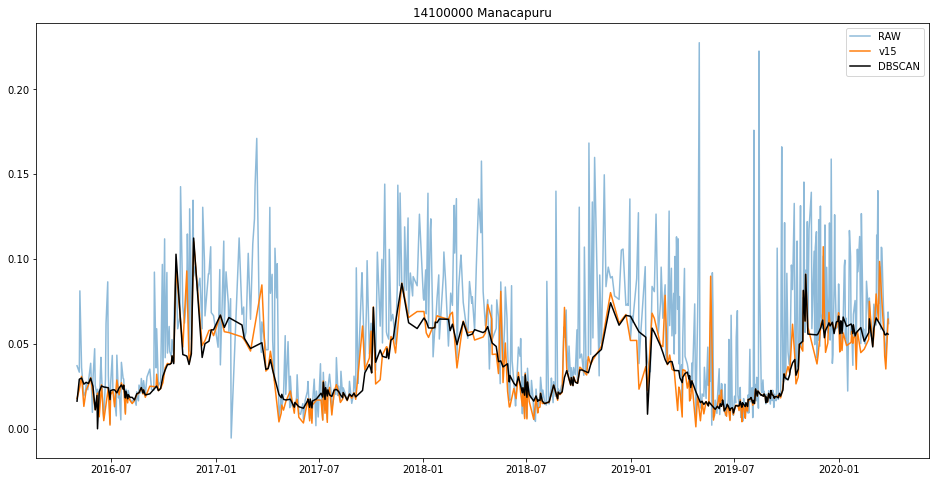

In [56]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.title('14100000 Manacapuru')
plt.plot(raw_dfs['14100000_manacapuru']['Date'],raw_dfs['14100000_manacapuru']['B17-865'],alpha=0.5,label='RAW')
plt.plot(v15_dfs['14100000_manacapuru_v15']['Date'],v15_dfs['14100000_manacapuru_v15']['B17-865'],label='v15')
plt.plot(dbs_manacapuru['Date'],dbs_manacapuru['B17-865'],label='DBSCAN', c='k')
plt.legend()

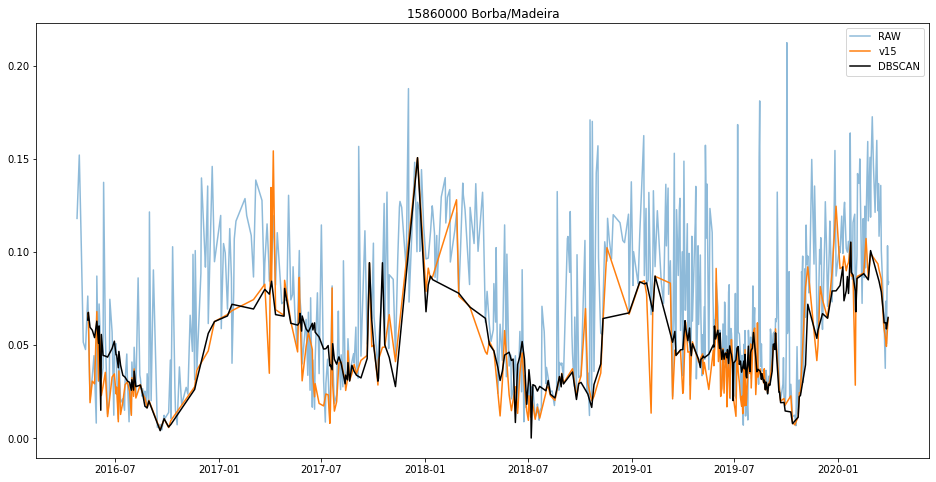

In [60]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.title('15860000 Borba/Madeira')
plt.plot(raw_dfs['15860000_borba_madeira']['Date'],raw_dfs['15860000_borba_madeira']['B17-865'],alpha=0.5,label='RAW')
plt.plot(v15_dfs['15860000_borba_madeira_v15']['Date'],v15_dfs['15860000_borba_madeira_v15']['B17-865'],label='v15')
plt.plot(dbs_borba['Date'],dbs_borba['B17-865'],label='DBSCAN', c='k')
plt.legend()

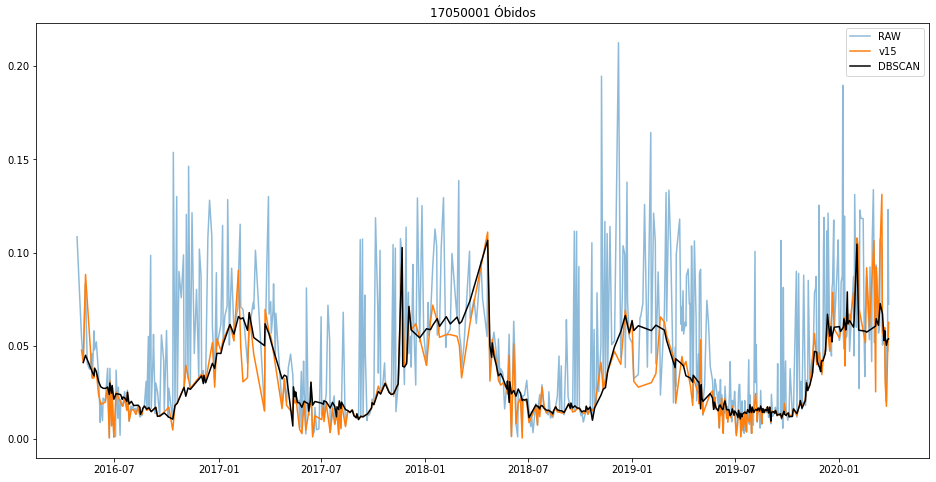

In [61]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.title('17050001 Óbidos')
plt.plot(raw_dfs['17050001_obidos']['Date'],raw_dfs['17050001_obidos']['B17-865'],alpha=0.5,label='RAW')
plt.plot(v15_dfs['17050001_obidos_v15b']['Date'],v15_dfs['17050001_obidos_v15b']['B17-865'],label='v15')
plt.plot(dbs_obidos['Date'],dbs_obidos['B17-865'],label='DBSCAN', c='k')
plt.legend()

## MOD / MYD / VNP

In [7]:
# MODIS-Terra
f_mod = Path('/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MOD09Q1_commun_noinf.xls')
# f_mod = Path('D:/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MOD09Q1_commun_noinf.xls')
df_mod = pd.read_excel(f_mod,sheet_name='MOD09Q1', converters={'Date': str})
df_mod['Date'] = df_mod['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_mod_srtd = df_mod.sort_values(by='Date')
df_mod_srtd['Datetime'] = pd.to_datetime(df_mod_srtd['Date'], errors='coerce')

# MODIS-Aqua
f_myd = Path('/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MYD09Q1_commun_noinf.xls')
df_myd = pd.read_excel(f_myd,sheet_name='MYD09Q1', converters={'Date': str})
df_myd['Date'] = df_myd['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_myd_srtd = df_myd.sort_values(by='Date')
df_myd_srtd['Datetime'] = pd.to_datetime(df_myd_srtd['Date'], errors='coerce')

# VIIRS
f_vir = Path('/d_drive_data/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_VNP09H1_commun_noinf.xls')
df_vir = pd.read_excel(f_vir,sheet_name='Report', converters={'Date': str})
df_vir['Date'] = df_vir['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_vir_srtd = df_vir.sort_values(by='Date')
df_vir_srtd['Datetime'] = pd.to_datetime(df_vir_srtd['Date'], errors='coerce')

In [8]:
# drop flags not in 1 and 2

df_mod_srtd = df_mod_srtd[(df_mod_srtd['flag qualite'] == 1) | (df_mod_srtd['flag qualite'] == 2)].copy()
df_myd_srtd = df_myd_srtd[(df_myd_srtd['flag qualite'] == 1) | (df_myd_srtd['flag qualite'] == 2)].copy()
df_vir_srtd = df_vir_srtd[(df_vir_srtd['flag qualite'] == 1) | (df_vir_srtd['flag qualite'] == 2)].copy()

len(df_mod_srtd),len(df_myd_srtd),len(df_vir_srtd)

(846, 785, 350)

## SPM

In [6]:
manacapuru_sed_xls = Path('/d_drive_data/processing/linux/14100000_manacapuru_v15_sedimentos.xlsx')
# manacapuru_sed_xls = Path('D:/processing/linux/14100000_manacapuru_v15_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'
df_manacapuru_sed = pd.read_excel(manacapuru_sed_xls,sheet_name='sedimentos')
# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_manacapuru_sed['pydate'] = [from_excel_ordinal(d) for d in df_manacapuru_sed['Data']]
# Reorder the DF by datetime 
df_manacapuru_sed.sort_values(by='pydate', inplace=True)

In [6]:
borba_sed_xls = Path('D:/processing/linux/15860000_borba_madeira_v15_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'
df_borba_sed = pd.read_excel(borba_sed_xls,sheet_name='sedimentos')
# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_borba_sed['pydate'] = [from_excel_ordinal(d) for d in df_borba_sed['Data']]
# Reorder the DF by datetime 
df_borba_sed.sort_values(by='pydate', inplace=True)

In [7]:
obidos_sed_xls = Path('D:/processing/linux/17050001_obidos_v15b_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'
df_obidos_sed = pd.read_excel(obidos_sed_xls,sheet_name='sedimentos')
# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_obidos_sed['pydate'] = [from_excel_ordinal(d) for d in df_obidos_sed['Data']]
# Reorder the DF by datetime 
df_obidos_sed.sort_values(by='pydate', inplace=True)

In [8]:
# Fix outlier for Óbidos
df_obidos_sed.drop(df_obidos_sed.tail(1).index,inplace=True)

In [15]:
dbs_manacapuru['SPM:GET:AMZ'] = SPM_GET_Amazon(band665=dbs_manacapuru['B8-665'], band865=dbs_manacapuru['B17-865'])
dbs_borba['SPM:GET:AMZ'] = SPM_GET_Amazon(band665=dbs_borba['B8-665'], band865=dbs_borba['B17-865'])
dbs_obidos['SPM:GET:AMZ'] = SPM_GET_Amazon(band665=dbs_obidos['B8-665'], band865=dbs_obidos['B17-865'])

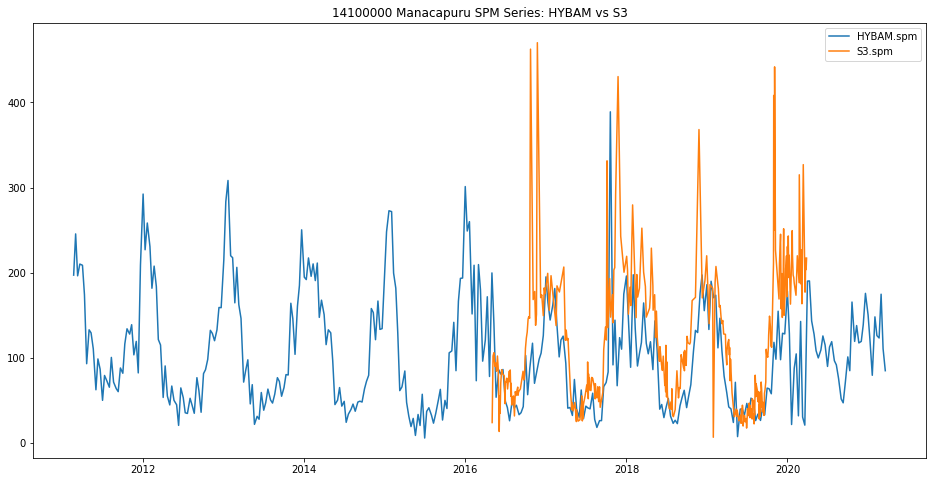

In [16]:
plt.figure(figsize=(16,8))
plt.title('14100000 Manacapuru SPM Series: HYBAM vs S3')
plt.plot(df_manacapuru_sed['pydate'],df_manacapuru_sed['Concentração (mg/L)'],label='HYBAM.spm')
plt.plot(dbs_manacapuru['Date'],dbs_manacapuru['SPM:GET:AMZ'],label='S3.spm')

plt.legend()

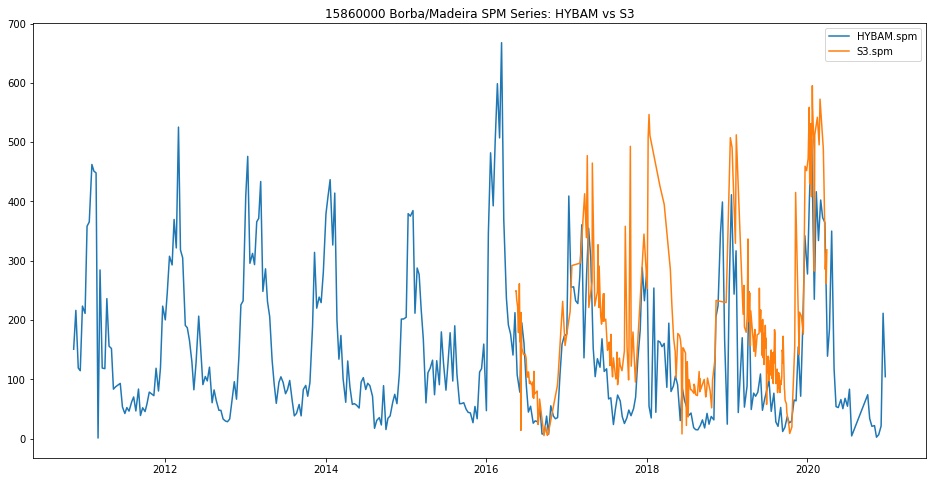

In [17]:
plt.figure(figsize=(16,8))
plt.title('15860000 Borba/Madeira SPM Series: HYBAM vs S3')
plt.plot(df_borba_sed['pydate'],df_borba_sed['Concentração (mg/L)'],label='HYBAM.spm')
plt.plot(dbs_borba['Date'],dbs_borba['SPM:GET:AMZ'],label='S3.spm')

plt.legend()

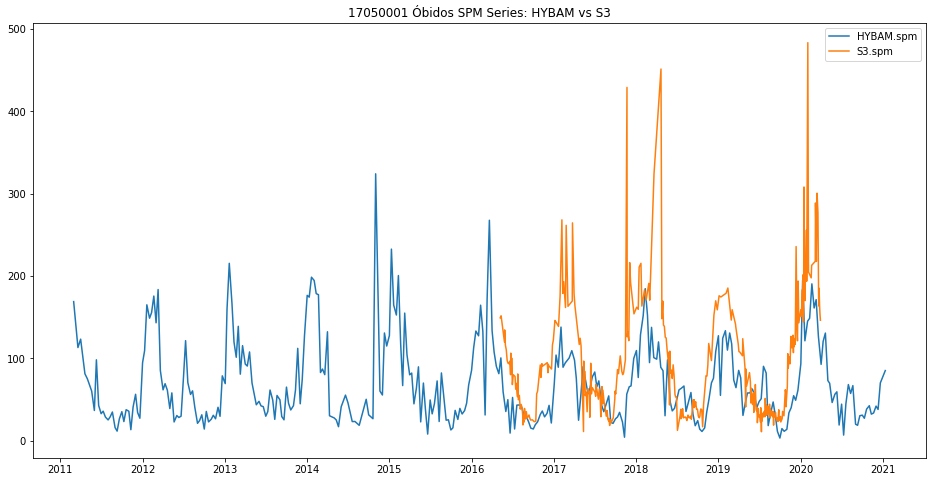

In [18]:
plt.figure(figsize=(16,8))
plt.title('17050001 Óbidos SPM Series: HYBAM vs S3')
plt.plot(df_obidos_sed['pydate'],df_obidos_sed['Concentração (mg/L)'],label='HYBAM.spm')
plt.plot(dbs_obidos['Date'],dbs_obidos['SPM:GET:AMZ'],label='S3.spm')

plt.legend()

## Matching for validation

In [12]:
# Testing for duplicate entries over input data
s3_dp = dbs_manacapuru.duplicated(keep=False,subset=['Date'])
mod_dp = df_mod_srtd.duplicated(keep=False,subset=['Date'])
myd_dp = df_myd_srtd.duplicated(keep=False,subset=['Date'])
vir_dp = df_vir_srtd.duplicated(keep=False,subset=['Date'])

len(df_mod_srtd[mod_dp]),len(df_myd_srtd[myd_dp]),len(df_vir_srtd[vir_dp]),len(dbs_manacapuru[s3_dp])

(0, 0, 0, 0)

## Multiply the composite rows to fill in the missing day gaps 

In [16]:
terra = df_mod_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
aqua = df_myd_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
viirs = df_vir_srtd.set_index('Datetime').resample('1D').ffill().reset_index()

In [17]:
len(terra),len(aqua),len(viirs)

(7298, 6431, 2947)

## Match Sentinel-3 observations

In [18]:
mod_mats3 = terra[terra['Datetime'].isin(dbs_manacapuru['Date'])]
myd_mats3 = aqua[aqua['Datetime'].isin(dbs_manacapuru['Date'])]
vir_mats3 = viirs[viirs['Datetime'].isin(dbs_manacapuru['Date'])]

In [19]:
len(mod_mats3),len(myd_mats3),len(vir_mats3),len(dbs_manacapuru)

(339, 338, 341, 351)

## Removing te S3 measures out of the other sensor bounds

In [20]:
s3_out = dbs_manacapuru[dbs_manacapuru['Date'] > mod_mats3['Datetime'].max()].index
s3_fusion = dbs_manacapuru.copy()
s3_fusion.drop(s3_out, inplace=True)
len(s3_fusion)

339

## Again...

In [21]:
mod_mats3 = terra[terra['Datetime'].isin(s3_fusion['Date'])]
myd_mats3 = aqua[aqua['Datetime'].isin(s3_fusion['Date'])]
vir_mats3 = viirs[viirs['Datetime'].isin(s3_fusion['Date'])]

In [22]:
len(mod_mats3),len(myd_mats3),len(vir_mats3),len(s3_fusion)

(339, 338, 339, 339)

In [23]:
myd_mats3['Datetime'].max()

Timestamp('2020-02-09 00:00:00')

In [24]:
vir_mats3['Datetime'].iloc[-2]

Timestamp('2020-02-09 00:00:00')

In [25]:
mod_mats3['Datetime'].iloc[-2]

Timestamp('2020-02-09 00:00:00')

In [26]:
s3_fusion['Date'].iloc[-2]

Timestamp('2020-02-09 00:00:00')

In [27]:
# Drop the last row
mod_mats3.drop(mod_mats3.tail(1).index,inplace=True)
vir_mats3.drop(vir_mats3.tail(1).index,inplace=True)
s3_fusion.drop(s3_fusion.tail(1).index,inplace=True)

len(mod_mats3),len(myd_mats3),len(vir_mats3),len(s3_fusion)

(338, 338, 338, 338)

In [28]:
# Check to see if the dates match
mod_mats3['Datetime'].max(),myd_mats3['Datetime'].max(),vir_mats3['Datetime'].max(),s3_fusion['Date'].max()

(Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-09 00:00:00'))

## CHECK IF EVERY SENSOR DATE FITS IN EACH OTHER'S

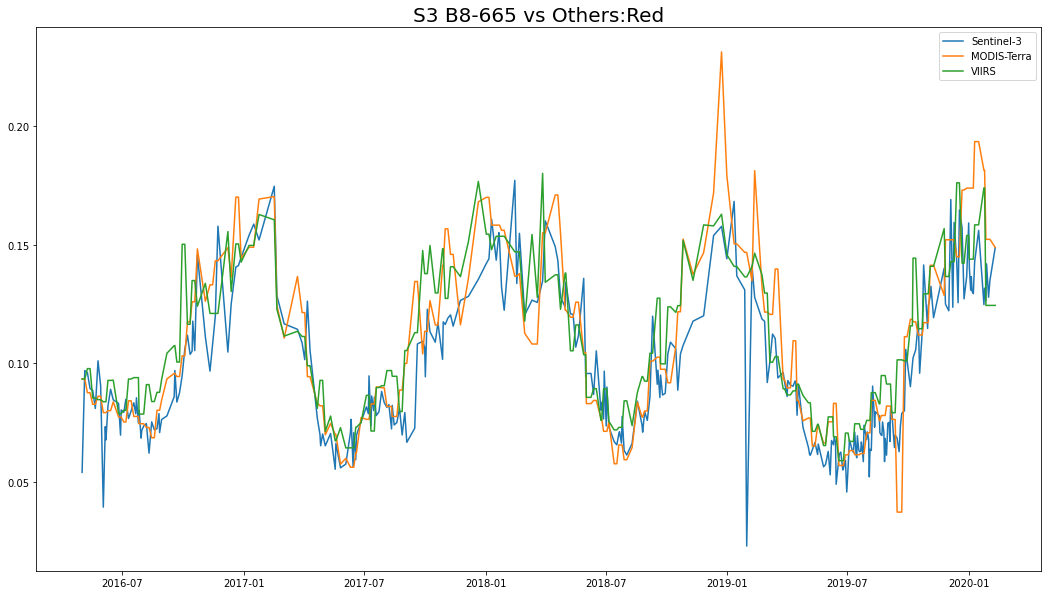

In [35]:
plt.rcParams['figure.figsize'] = [18, 10]
plt.title('S3 B8-665 vs Others:Red',fontsize=20)
plt.plot(s3_fusion['Date'],s3_fusion['B8-665'],label='Sentinel-3')
plt.plot(mod_mats3['Datetime'],mod_mats3['Bande rouge estimee']/10000,label='MODIS-Terra')
# plt.plot(myd_mats3['Datetime'],myd_mats3['Bande rouge estimee']/10000,label='MODIS-Aqua')
plt.plot(vir_mats3['Datetime'],vir_mats3['Bande rouge estimee']/10000,label='VIIRS')

plt.legend()

## CREATING A SINGLE DF WITH ALL 4 SENSORS

In [120]:
# https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values

s3_fusion.reset_index(drop=True, inplace=True)
mod_mats3.reset_index(drop=True, inplace=True)
myd_mats3.reset_index(drop=True, inplace=True)
vir_mats3.reset_index(drop=True, inplace=True)

rouge_data = pd.concat([s3_fusion['B8-665'],
                        mod_mats3['Bande rouge estimee']/10000,
                        myd_mats3['Bande rouge estimee']/10000,
                        vir_mats3['Bande rouge estimee']/10000], axis=1,
                       keys=['S3', 'MOD', 'MYD', 'VIR'])

rouge_data.index = s3_fusion['Date']

In [121]:
# rouge_data.to_csv('sat_match.csv')

In [122]:
ir_data = pd.concat([s3_fusion['B17-865'],
                        mod_mats3['Bande IR estimee']/10000,
                        myd_mats3['Bande IR estimee']/10000,
                        vir_mats3['Bande IR estimee']/10000], axis=1,
                       keys=['S3', 'MOD', 'MYD', 'VIR'])

ir_data.index = s3_fusion['Date']

In [123]:
# ir_data.to_csv('sat_match_ir.csv')

## PLOTING TO TEST IF IT WORKED

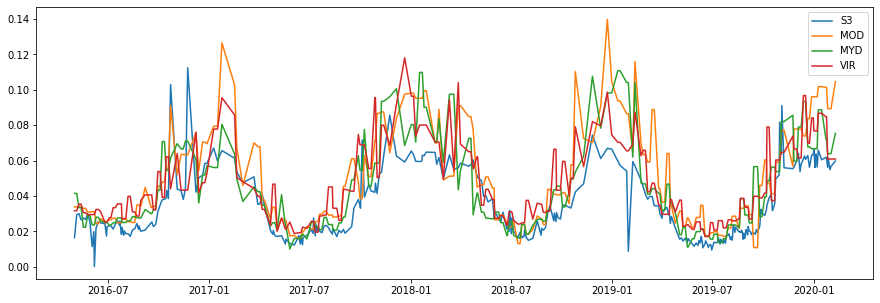

In [124]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(ir_data.S3,label='S3')
plt.plot(ir_data.MOD,label='MOD')
plt.plot(ir_data.MYD,label='MYD')
plt.plot(ir_data.VIR,label='VIR')
plt.legend()

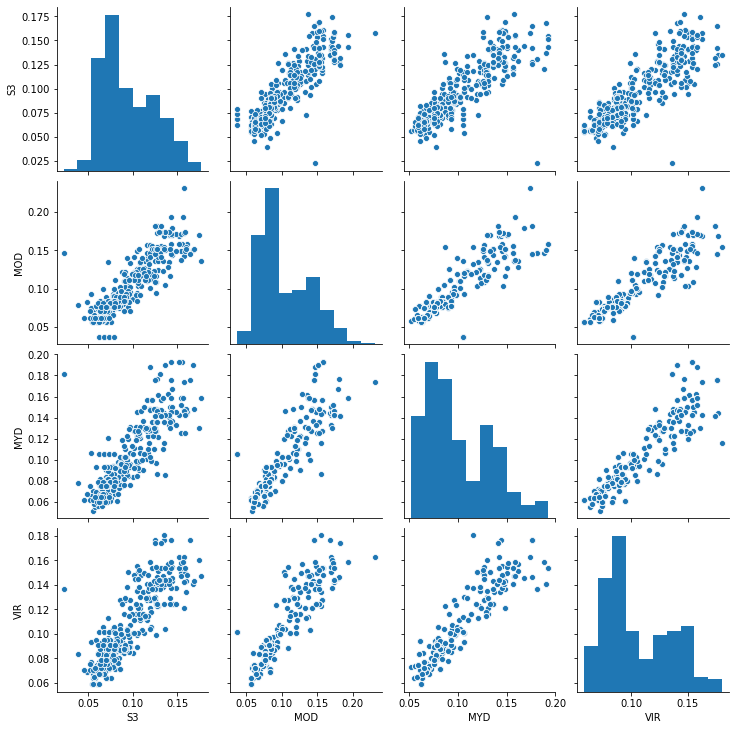

In [126]:
sns.pairplot(rouge_data)

## COMPUTING STATISTICS

## r²

In [127]:
from sklearn.metrics import r2_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

r2dict = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = r2_score(ir_data[sensor],ir_data[col]) # y_true / y_pred 
        r2dict[f'{sensor}:{col}'] = result

r2dict

{'S3:S3': 1.0,
 'S3:MOD': -0.08563531047567063,
 'S3:MYD': 0.2562904985505984,
 'S3:VIR': 0.18948778408928613,
 'MOD:S3': 0.46362894204310046,
 'MOD:MOD': 1.0,
 'MOD:MYD': 0.6666527860482823,
 'MOD:VIR': 0.7130919534982063,
 'MYD:S3': 0.5523244326835008,
 'MYD:MOD': 0.5938602313635082,
 'MYD:MYD': 1.0,
 'MYD:VIR': 0.6971975306035583,
 'VIR:S3': 0.37617566726608154,
 'VIR:MOD': 0.5530446922901522,
 'VIR:MYD': 0.6128296458176525,
 'VIR:VIR': 1.0}

## RMSE

In [128]:
from sklearn.metrics import mean_squared_error as mse

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmsedict = {}
rmsedict_yt = {}
rmsedict_yp = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = rmse(ir_data[col],ir_data[sensor])
        rmsedict[f'{sensor}:{col}'] = result
        rmsedict_yt[f'{sensor}:{col}'] = (result/ir_data[sensor].mean())*100 # y_true
        rmsedict_yp[f'{sensor}:{col}'] = (result/ir_data[col].mean())*100 # y_pred
        

print(rmsedict,'\n')

print(rmsedict_yt,'\n')
print(rmsedict_yp,'\n')

{'S3:S3': 0.0, 'S3:MOD': 0.019567678655255296, 'S3:MYD': 0.016195672736401864, 'S3:VIR': 0.01690741099654098, 'MOD:S3': 0.019567678655255296, 'MOD:MOD': 0.0, 'MOD:MYD': 0.015426061365731457, 'MOD:VIR': 0.014311264356300406, 'MYD:S3': 0.016195672736401864, 'MYD:MOD': 0.015426061365731457, 'MYD:MYD': 0.0, 'MYD:VIR': 0.013319778487435617, 'VIR:S3': 0.01690741099654098, 'VIR:MOD': 0.014311264356300406, 'VIR:MYD': 0.013319778487435617, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 59.16570996648222, 'S3:MYD': 48.96996177810108, 'S3:VIR': 51.12200547287679, 'MOD:S3': 42.54243249448607, 'MOD:MOD': 0.0, 'MOD:MYD': 33.538069889101415, 'MOD:VIR': 31.11437020789073, 'MYD:S3': 38.973386026346404, 'MYD:MOD': 37.121387561843775, 'MYD:MYD': 0.0, 'MYD:VIR': 32.05281294734183, 'VIR:S3': 38.3454473688043, 'VIR:MOD': 32.45747289563335, 'VIR:MYD': 30.208815829850415, 'VIR:VIR': 0.0} 

{'S3:S3': 0.0, 'S3:MOD': 42.54243249448607, 'S3:MYD': 38.973386026346404, 'S3:VIR': 38.3454473688043, 'MOD:S3': 59.1657099664

## MAPE

In [129]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapedict = {}

for sensor in list(ir_data.columns):
    for col in ir_data:
        result = mape(ir_data[sensor],ir_data[col])
        mapedict[f'{sensor}:{col}'] = result
        
mapedict

{'S3:S3': 0.0,
 'S3:MOD': 101.72364378054542,
 'S3:MYD': 77.73299665743232,
 'S3:VIR': 99.24369728532152,
 'MOD:S3': 29.885096310406983,
 'MOD:MOD': 0.0,
 'MOD:MYD': 25.4165988320263,
 'MOD:VIR': 25.20165119569942,
 'MYD:S3': 23.906712020233876,
 'MYD:MOD': 25.564412201037158,
 'MYD:MYD': 0.0,
 'MYD:VIR': 25.689226293428604,
 'VIR:S3': 29.13008086018749,
 'VIR:MOD': 22.615075962993984,
 'VIR:MYD': 20.67309856521286,
 'VIR:VIR': 0.0}

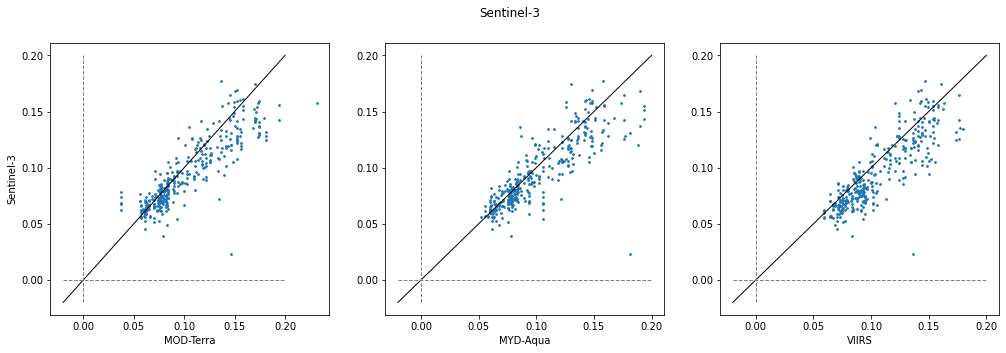

In [130]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('Sentinel-3')

ax1.scatter(rouge_data.MOD, rouge_data.S3, s=3)
ax2.scatter(rouge_data.MYD, rouge_data.S3, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.S3, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('Sentinel-3')

ax1.set_xlabel('MOD-Terra')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_s3.png', bbox_inches='tight')

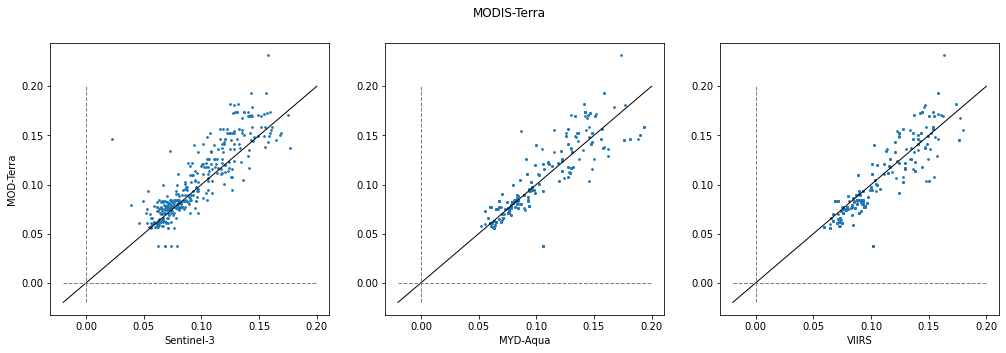

In [131]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Terra')

ax1.scatter(rouge_data.S3, rouge_data.MOD, s=3)
ax2.scatter(rouge_data.MYD, rouge_data.MOD, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.MOD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MOD-Terra')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MYD-Aqua')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_mod.png', bbox_inches='tight')

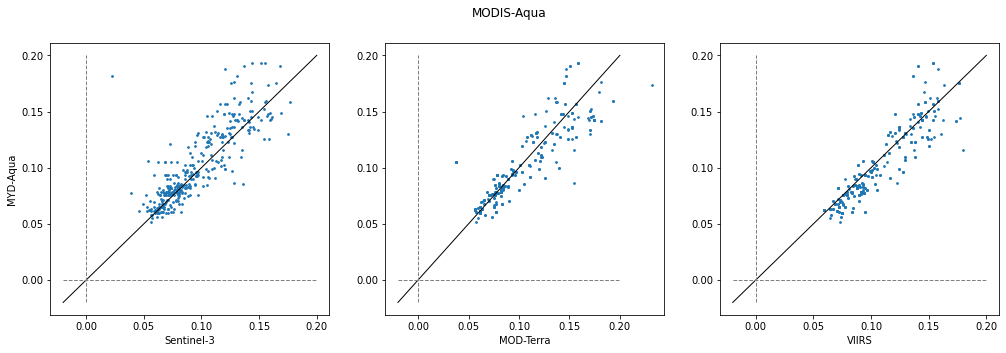

In [132]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('MODIS-Aqua')

ax1.scatter(rouge_data.S3, rouge_data.MYD, s=3)
ax2.scatter(rouge_data.MOD, rouge_data.MYD, s=3)
ax3.scatter(rouge_data.VIR, rouge_data.MYD, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('MYD-Aqua')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('VIIRS')

plt.savefig('compare_myd.png', bbox_inches='tight')

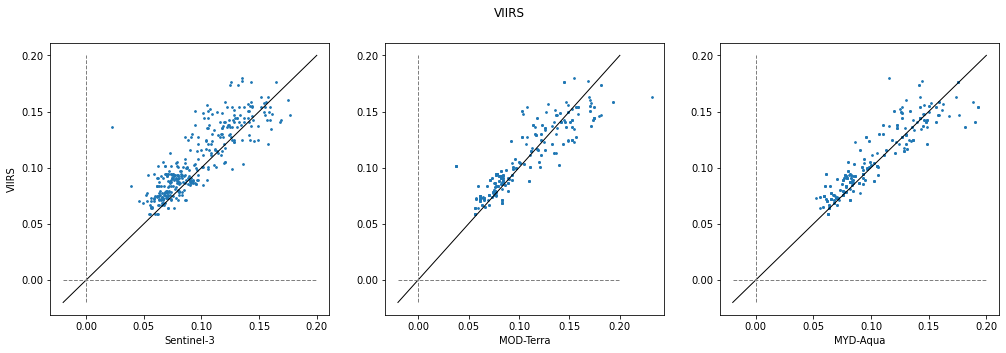

In [133]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('VIIRS')

ax1.scatter(rouge_data.S3, rouge_data.VIR, s=3)
ax2.scatter(rouge_data.MOD, rouge_data.VIR, s=3)
ax3.scatter(rouge_data.MYD, rouge_data.VIR, s=3)


ax1.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax1.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax1.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax2.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax2.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax2.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)

ax3.plot([-0.02, 0.2], [-0.02, 0.2], 'k-', linewidth=1)
ax3.plot([0, 0], [-0.02, 0.2], c='grey', linestyle='dashed', linewidth=1)
ax3.plot([-0.02, 0.2], [0, 0], c='grey', linestyle='dashed', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('VIIRS')

ax1.set_xlabel('Sentinel-3')
ax2.set_xlabel('MOD-Terra')
ax3.set_xlabel('MYD-Aqua')

plt.savefig('compare_vir.png', bbox_inches='tight')

## Outlier days

In [148]:
px_dbs_manacapuru = dbs_manacapuru.copy()
px_dbs_manacapuru.set_index('Date', inplace=True)

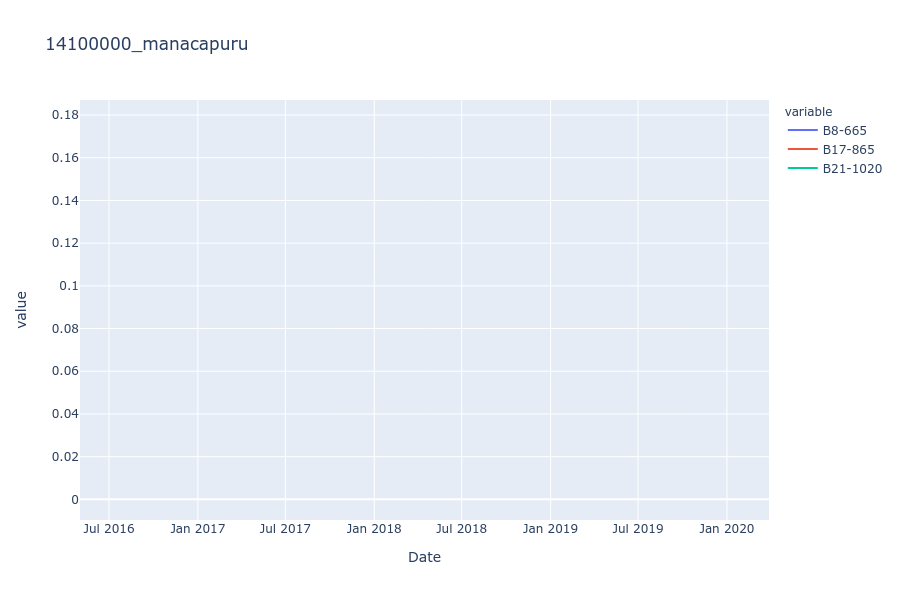

In [149]:
px.line(px_dbs_manacapuru, y=['B8-665','B17-865','B21-1020'], height=600, title="14100000_manacapuru")

In [150]:
out_20161023 = open_radiometry(Path(r'D:\processing\linux\14100000_manacapuru_v15\S3A_OL_2_WFR____20161023T134933_20161023T135133_20171104T083102_0119_010_124______MR1_R_NT_002.csv'))

In [153]:
db_scan(out_20161023, ['B17-865', 'B21-1020'], eps=0.01)

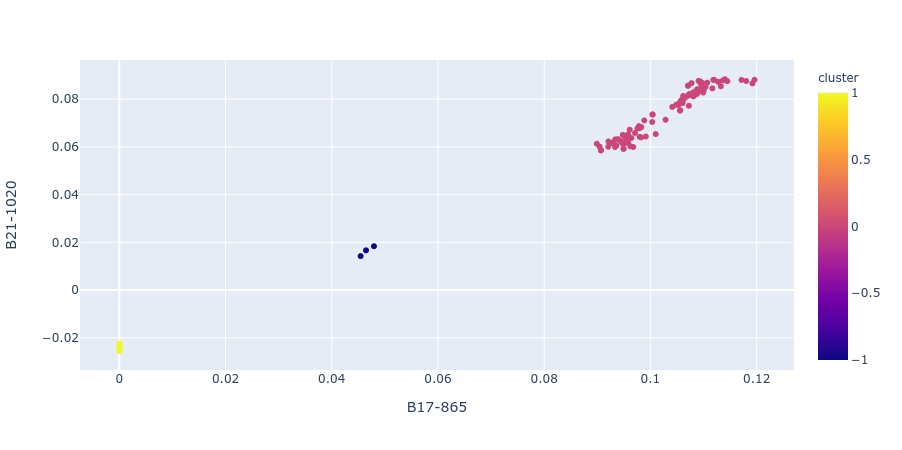

In [154]:
px.scatter(out_20161023, x=out_20161023['B17-865'], y=out_20161023['B21-1020'], color='cluster')

## CAMS Inverse Artifact

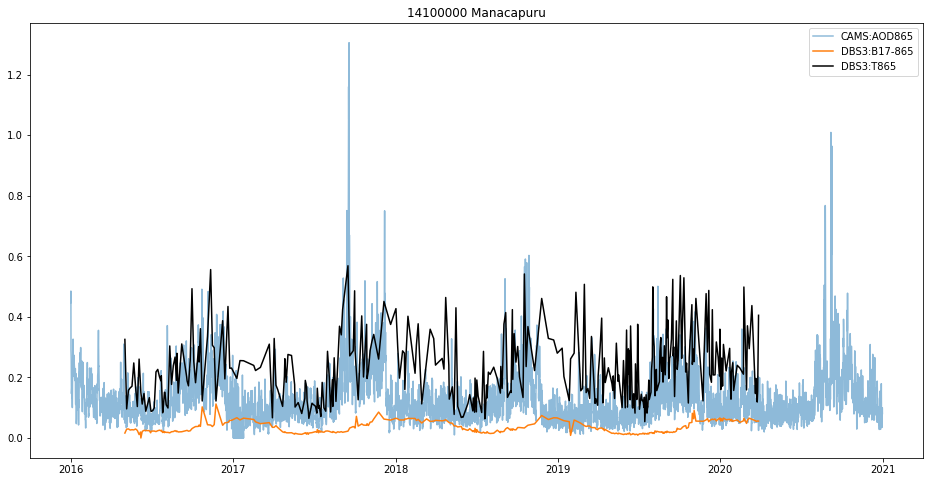

In [75]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.title('14100000 Manacapuru')
plt.plot(df_cams_manacapuru['pydate'],df_cams_manacapuru['AOD865'],alpha=0.5,label='CAMS:AOD865')
plt.plot(dbs_manacapuru['Date'],dbs_manacapuru['B17-865'],label='DBS3:B17-865')
plt.plot(dbs_manacapuru['Date'],dbs_manacapuru['T865:float'],c='k',label='DBS3:T865')
# plt.ylim(top=0.6)
plt.legend()